# Improving performance and low-level distributed computing

## Performance

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

**Functions to optimize**

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

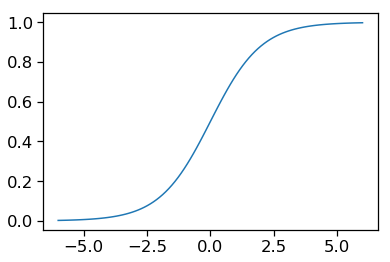

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

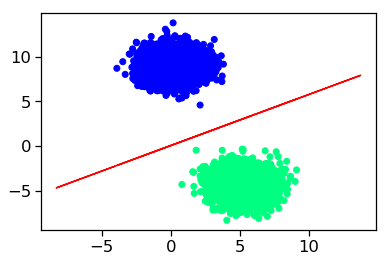

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

In [8]:
β = np.zeros(p+1)
β

array([0., 0., 0.])

**1**. (10 points)

Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. 

In [9]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [10]:
def logistic_new(x):
    """Logistic function with one np.exp call."""
    return 1/(1 + np.exp(x)**(-1))

In [11]:
from timeit import timeit

In [12]:
%timeit logistic_new(x)

109 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit logistic(x)

167 ms ± 7.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print ('The updated version of sigmoid function is', round(170/102,3),'times faster')

The updated version of sigmoid function is 1.667 times faster


**2**. (20 points) 

Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [15]:
import numba

**1. Use the @vectorize decorator to create a ufunc version of the logistic function and call this logistic_numba_cpu with function signatures of float64(float64). Create another function called logistic_numba_parallel by giving an extra argument to the decorator of target=parallel (5 points).**

In [16]:
@vectorize ([float64(float64)])
def logistic_numba_cpu(x):
    return 1/(1+np.exp(-x))

In [17]:
@vectorize ([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    return 1/(1+np.exp(-x))

**2. For each function, check that the answers are the same as with the original logistic function using np.testing. Use %timeit to compare the three logistic functions (5 points).**

In [18]:
np.testing.assert_equal(logistic_numba_cpu(x), logistic_numba_parallel(x))

In [19]:
assert(np.allclose(logistic_numba_cpu(x),logistic(x)))
#When function "assert_equal" is used, we observe a absolute difference of 4.4*10^(-16), so while these functions are not identical, the outputs are very close.

The maximum absolute difference between the two arrays is 2.22044605e-16, which is extremely small, so we may conclude that the functions are almost equivalent. 

In [20]:
%timeit logistic(x)

171 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit logistic_numba_cpu(x)

97.6 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit logistic_numba_parallel(x)

164 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The fastest pefromance has a logistic_numba_cpu function, exceeding the speed of the original logistic function more than twice.

**3. Now use @jit to create a JIT_compiled version of the logistic and gd functions, calling them logistic_numba and gd_numba. Provide appropriate function signatures to the decorator in each case. (5 points)**

In [23]:
@jit(float64[:](float64[:]))
def logistic_numba(x):
    return 1/(1+np.exp(-x))

In [24]:
@jit(float64[:](float64[:,:], float64[:], float64[:], float64, int64))
#All arguments have the type float except the numba of iterations niter of an integer type.
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

**4. Compare the two gradient descent functions gd and gd_numba for correctness and performance. (5 points)**

In [25]:
%timeit logistic(x)

218 ms ± 45.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit logistic_numba(x)

88.2 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
assert(np.allclose(logistic_numba(x),logistic(x)))

The speed of the jit-compiled version is approximately two times faster than the speed of the original version.
While two functions are not identical, the maximum differences (both relative and absolute) are extremely small, so we conclude that these functions are almost equivalent.

In [28]:
assert(np.allclose(gd(X, y, β, α, niter), gd_numba(X, y, β, α, niter)))

In [29]:
%timeit gd(X, y, β, α, niter)

239 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit gd_numba(X, y, β, α, niter)

196 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Original version of the gradient descent and jit-compiled versions are identical. The jit-compiled version is approximately 1.3 times faster.

**3**. (20 points) 

Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate (-a)` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [39]:
%%cython --annotate
#Annotate - highlights the slowest performing parts of the code.

import cython
import numpy as np
cimport numpy as np #Gives an access to Numpy C API
from libc.math cimport exp 

@cython.boundscheck(False) #Indexing operations in the code will not cause any IndexErrors to be raised. 
@cython.wraparound(False) #Cython will not ensure that python indexing (relative to the end) is not used.
@cython.cdivision(True) #No checks are performed to adjust the remainder and quotient operators C types to match Python. 

def logistic_cython(double[:] x): #Function's argument is an 1D np array of float type.
    'Sigmoid function'
    
    cdef int i,n
    n=x.shape[0] #Number of elements in the array.
    cdef double[:] y = np.empty(n) #Create an empty 1D np array of length n.
    for i in range(n): y[i] = 1/(1 + exp(x[i])**(-1))
    return y

@cython.boundscheck(False) #Indexing operations in the code will not cause any IndexErrors to be raised. 
def gd_cython(double[:, :] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient descent algorihtm."""    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1] 
    cdef double[:] epsilon, y_pred, grad
    cdef double[:, :] Xt 
    cdef int i
    #Declaring the types for all variables and initializing them with empty np arrays.
    
    epsilon = np.empty(n)
    y_pred = np.empty(n)
    grad = np.empty(p)  
    Xt = X.T

    for i in range(niter):
        y_pred = logistic_cython(np.dot(X, beta))
        epsilon[i] = y[i] - y_pred[i]
        grad = np.dot(Xt, epsilon) / n
        beta[i] =  beta[i] + alpha * grad[i]
    return beta

In [32]:
%timeit logistic_cython(x)

225 ms ± 71.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit logistic_numba_cpu(x)

128 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
assert(np.allclose(logistic_cython(x), logistic_numba_cpu(x)))

In [35]:
niter = 1000
alpha = 0.01
beta = np.zeros(p+1)

In [40]:
%timeit gd(X, y, beta, alpha, niter)

155 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit gd_cython(X, y, beta, alpha, niter)

94.9 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
np.testing.assert_array_almost_equal(gd(X, y, beta, alpha, niter), gd_cython(X, y, beta, alpha, niter))

Cython version of the gradient descent function runs approximately 40% faster than a regular version. 

**4**. (50 points)

Write a program using `spark` to find 5 most common k-mers (shifting windows of length k) in the C. elegans genome. Ignore case when processing k-mers. You can work one line at a time - we will ignore k-mers that wrap around lines. You should write a function that takes a path to FASTA files and a value for k, and returns an key-value RDD of k-mer counts. Remember to strip comment lines that begin with '>' from the anlaysis. 

**Note**: 

- Use the low level RDD interface for this exercise.
- The textFile method takes an optional second argument for controlling the number of partitions of the file. By default, Spark creates one partition for each block of the file (blocks being 128MB by default in HDFS), but you can also ask for a higher number of partitions by passing a larger value. Please set this paramter to 60 - it will speed up processing.

**Check**: Use the C. elegans genome at `/data/c_elegans/*fa`. You should get 

```
[
(u'ATATATATATATATATATAT', 2168), 
(u'TATATATATATATATATATA', 2142), 
(u'CTCTCTCTCTCTCTCTCTCT', 1337), 
(u'TCTCTCTCTCTCTCTCTCTC', 1327), 
(u'AGAGAGAGAGAGAGAGAGAG', 1007)
]
```

**Instructions for local Spark installation**

If you are doing this on your own machine, you can download the DNA sequence from 

ftp://ftp.wormbase.org/pub/wormbase/releases/WS272/species/c_elegans/PRJNA13758/c_elegans.PRJNA13758.WS272.genomic.fa.gz

The results might be slightly different since this may be a newer consensus sequence than the one on HDFS in the Docker container.

You will probably need to also load SparkContext explicitly if doing this on your laptop.

```python
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.SparkContext()
```

In [40]:
from pyspark.sql import SparkSession

spark = SparkSession \
     .builder \
     .appName("Homework 5: genomics") \
     .getOrCreate() 
sc=spark.sparkContext
path='/Users/iuliia/bios-823-2019/homework/c_elegans.PRJNA13758.WS272.genomic.fa'
file=sc.textFile(path, 60)

In [41]:
#Explore the structure of the file.
for line in file.takeSample(True, 5): print (line) 
print ('Number of lines in the file:', file.count())
print ('Number of lines starting with < :', file.filter(lambda line: line.startswith('>')).count())

TGCAACAAGTTGTTTGAGTTTCGAATTCACTGAAATTTAATCCCTCTGGCTAAAACTGGT
CACAGACTACAAAGACTACATAGACTACAAACTATGGACAAACGGAATAAGCGCTTTATA
AAATCTATTTGAATTAAATTATTTAAAATAAACTAACACCTTATCTCCTGTCGTTTCGAT
ATTTGACATTCCAAATTTCAGATATTTATTGCACCTTTTTTCTCTTTTGTAGATTTCTAA
GACCCTGAAAATTGTTTTTTTTTCAAAAATTTTAAATTCCGAAATTCCAGAAAAACTCAC
Number of lines in the file: 1671451
Number of lines starting with < : 7


In [42]:
def f(path, k):
#Returns 5 most common k-mers from the genome.
    frequency = (sc.textFile(path, 60).map(lambda line: line.upper())
              .filter(lambda line: line.strip() and line[0]!='>')
              #Reads each line from element 0 to the last possible to fit the kmer of length k.
              .flatMap(lambda line: [line[symbol:symbol+k] for symbol in range(0, len(line) - k + 1)])
              #Calculating the number of appearences for each sequence of k-length kmers and 
              #taking five the most frequently appearing ones. 
              .map(lambda kmers: (kmers, 1)).reduceByKey(lambda a, b: a + b).takeOrdered(5, key=lambda x: -x[1])) 
              
    return frequency

In [44]:
path='/Users/iuliia/bios-823-2019/homework/c_elegans.PRJNA13758.WS272.genomic.fa'
f(path, k=20)

[('ATATATATATATATATATAT', 2217),
 ('TATATATATATATATATATA', 2184),
 ('CTCTCTCTCTCTCTCTCTCT', 1373),
 ('TCTCTCTCTCTCTCTCTCTC', 1361),
 ('AGAGAGAGAGAGAGAGAGAG', 1033)]